Test different methods of background subtraction

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

machine = 'nancep' # dias or nancep

if machine=='dias': # on dias machines
    data_dir    = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs     = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir    = '/data/mnedal'
    folder_path = '/data/mnedal/outputs/data'
    outputs     = '/data/mnedal/outputs/plots'

In [2]:
mydate = '20250326'

nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
for f in enumerate(nenufar_files):
    print(f)

(0, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesI_typeIII_G1.pkl')
(1, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1.pkl')
(2, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1_fullres.pkl')
(3, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesI_typeIII_G2.pkl')
(4, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesV_over_I_typeIII_G2.pkl')
(5, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl')
(6, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesV_over_I_typeIII_G3.pkl')
(7, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_104500_20250325_104900_stokesI_typeIII_G4.pkl')
(8, '/data/mnedal/outputs/data/nenufar/combined_dyspec_20250325_1045

In [5]:
SRB_groupname = 'typeII' # typeIII_G1, typeIII_G2, typeIII_G3, typeIII_G4, typeII

g_files = [f for f in nenufar_files if mydate in f and f.endswith(f'{SRB_groupname}.pkl')] # find the filenames that end with G1
print(*g_files, sep='\n')

stokesI_filename  = [f for f in g_files if 'stokesI' in f][0]
stokesVI_filename = [f for f in g_files if 'stokesV_over_I' in f][0]

df_int = pd.read_pickle(stokesI_filename)
df_pol = pd.read_pickle(stokesVI_filename)

# Convert arb. unit to dB for Stokes I
df_int = 10 * np.log10(df_int) # Convert the amplitude to decibels

/data/mnedal/outputs/data/nenufar/combined_dyspec_20250326_091312_20250326_095609_stokesI_typeII.pkl
/data/mnedal/outputs/data/nenufar/combined_dyspec_20250326_091312_20250326_095609_stokesV_over_I_typeII.pkl


<b>Original cadence:</b>
* Frequency resolution: 6.10 kHz
* Time resolution: 20.97 ms

In [6]:
print('Stokes I:')
print(f'Frequency resolution: {np.median(np.diff(df_int.columns)*1e3):.2f} kHz')
print(f'Time resolution: {np.median(np.diff(df_int.index)/np.timedelta64(1,"ms")):.2f} ms')
print(f'Data shape: {df_int.shape}\n')

print('Stokes V/I:')
print(f'Frequency resolution: {np.median(np.diff(df_pol.columns)*1e3):.2f} kHz')
print(f'Time resolution: {np.median(np.diff(df_pol.index)/np.timedelta64(1,"ms")):.2f} ms')
print(f'Data shape: {df_pol.shape}')

Stokes I:
Frequency resolution: 97.66 kHz
Time resolution: 20.97 ms
Data shape: (122882, 640)

Stokes V/I:
Frequency resolution: 97.66 kHz
Time resolution: 20.97 ms
Data shape: (122882, 640)


## Downsample in time and try different background subtraction methods

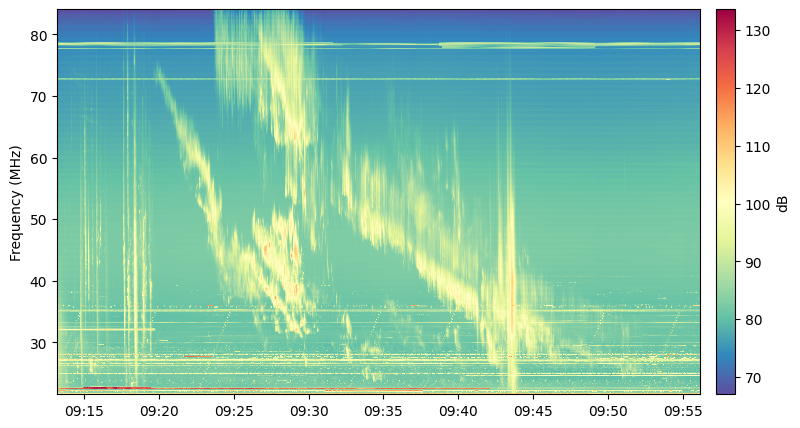

In [7]:
df_int_1s = df_int.resample('1S').mean()

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(df_int_1s.index, df_int_1s.columns, df_int_1s.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

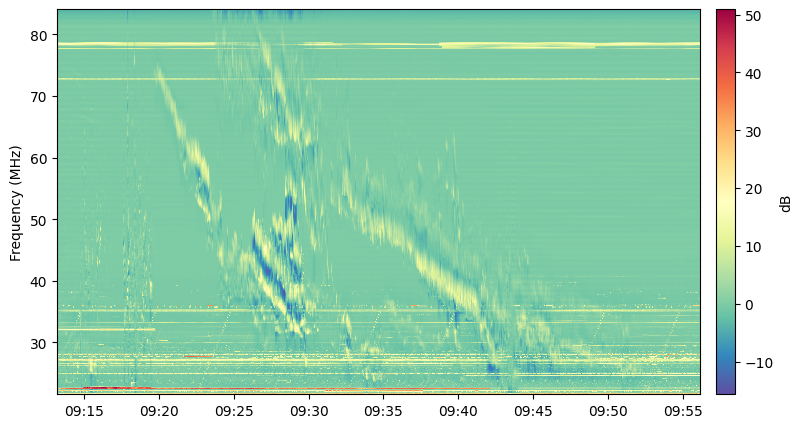

In [8]:
### Median filter background subtraction
from scipy.ndimage import median_filter
background = median_filter(df_int_1s, size=(1, 101))
dyspec_subtracted = df_int_1s - background

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

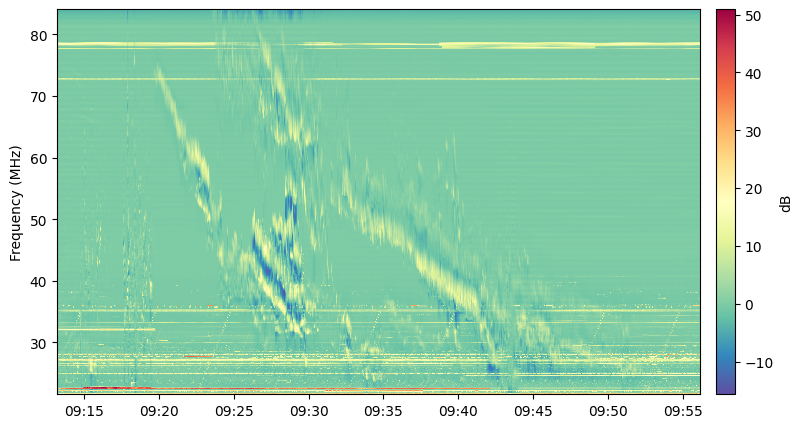

In [9]:
### Running median or percentile filter (along time axis)
from scipy.ndimage import percentile_filter
background = percentile_filter(df_int_1s, percentile=50, size=(1, 101))
dyspec_subtracted = df_int_1s - background

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

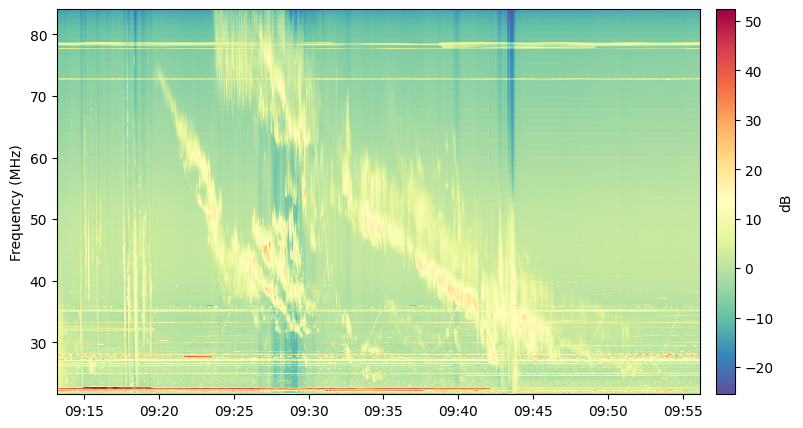

In [10]:
### Row-wise median or median subtraction
background = np.nanmedian(df_int_1s, axis=1, keepdims=True)
dyspec_subtracted = df_int_1s - background

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

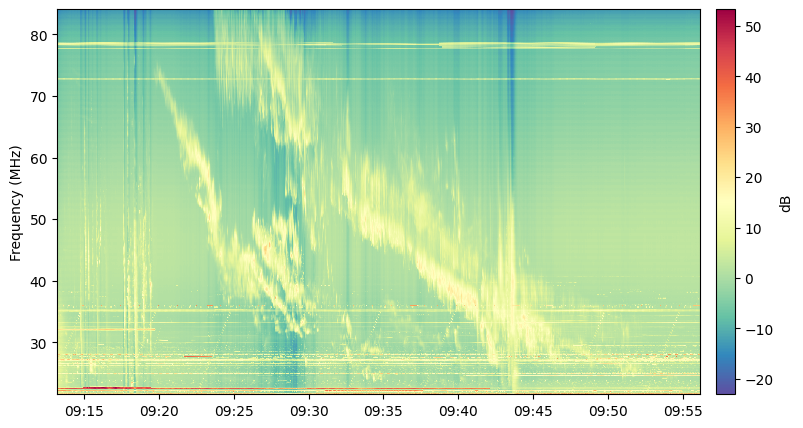

In [11]:
### Row-wise mean or mean subtraction
background = np.nanmean(df_int_1s, axis=1, keepdims=True)
dyspec_subtracted = df_int_1s - background

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

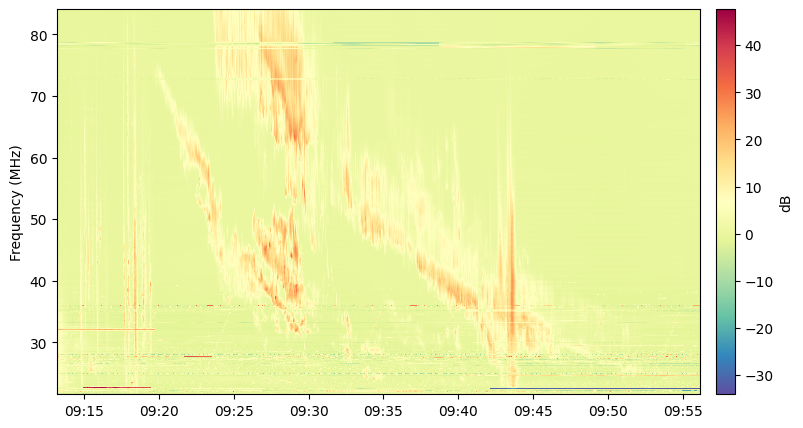

In [15]:
dyspec_subtracted = df_int_1s - np.tile(np.nanmedian(df_int_1s,0), (df_int_1s.shape[0],1))

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

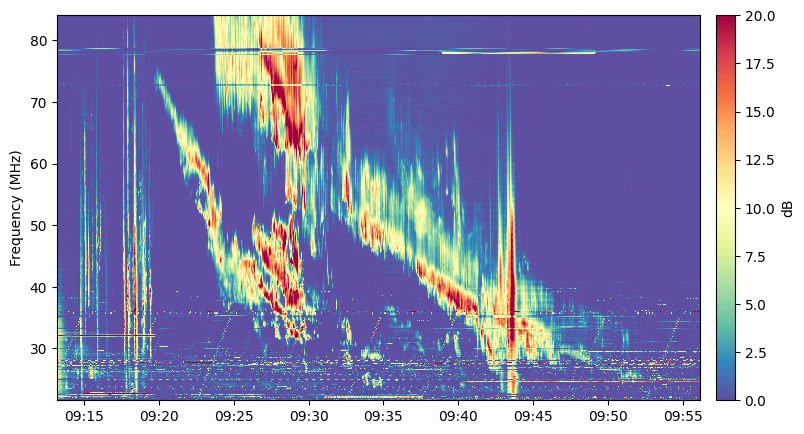

In [18]:
fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(dyspec_subtracted.index, dyspec_subtracted.columns, dyspec_subtracted.T,
                   vmin=0, vmax=20,
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

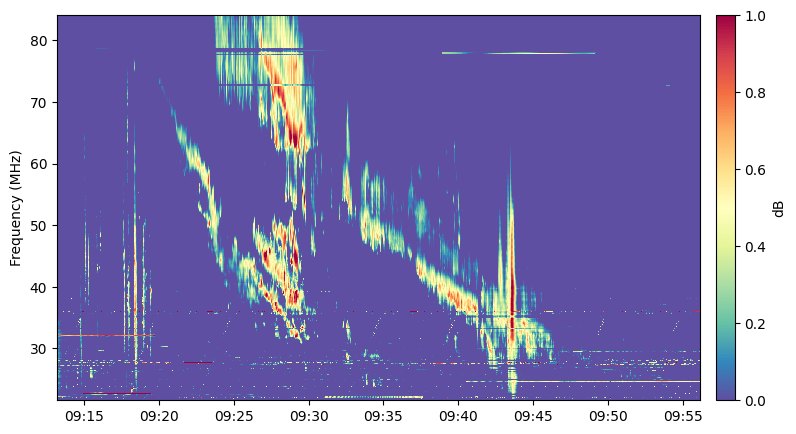

In [13]:
### Contrast stretching or clipping
vmin = np.nanpercentile(dyspec_subtracted, 85)   # gives the value below which 85% of the pixels lie (ignoring NaNs)
vmax = np.nanpercentile(dyspec_subtracted, 99.9) # gives the value below which 99.9% of the pixels lie
normalized = np.clip((dyspec_subtracted - vmin) / (vmax - vmin), 0, 1)

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(normalized.index, normalized.columns, normalized.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

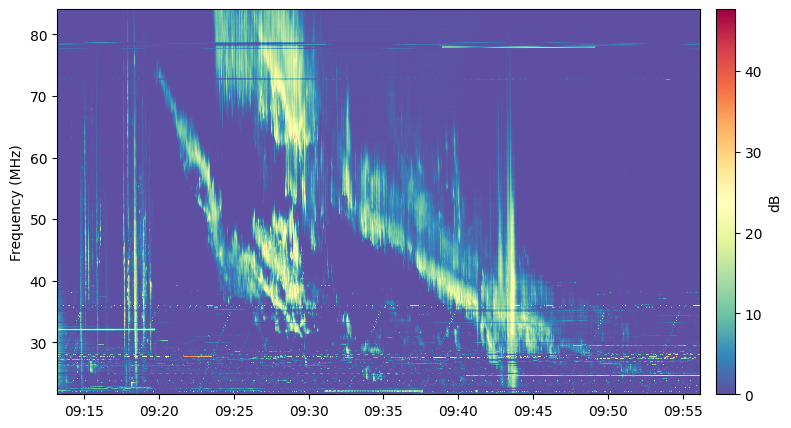

In [14]:
normalized = np.clip(dyspec_subtracted, a_min=0, a_max=None)

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(normalized.index, normalized.columns, normalized.T, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

Found 61 quiet time indices.


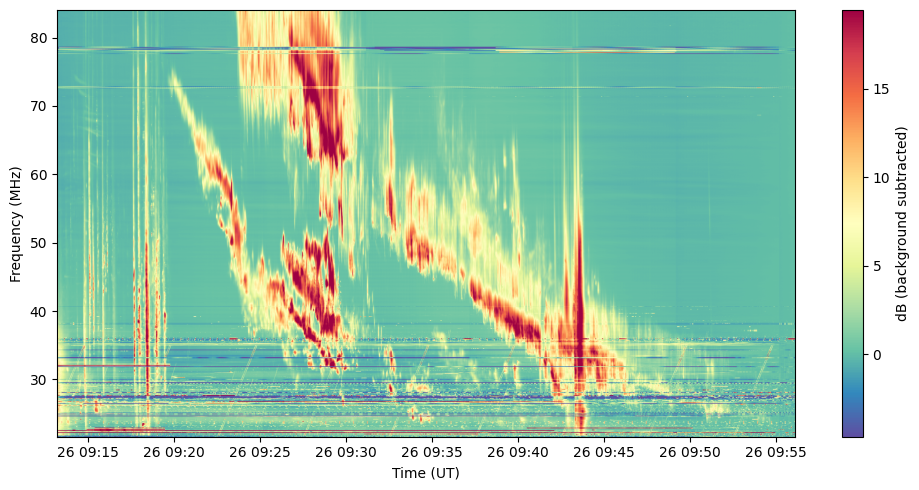

In [47]:
# Convert your string times to pandas.Timestamp
quiet_start = pd.Timestamp('2025-03-26T09:55:00')
quiet_end   = pd.Timestamp('2025-03-26T09:56:00')

data  = df_int_1s.values
times = pd.Series(df_int_1s.index)
freqs = df_int_1s.columns

# Now find quiet indices
quiet_indices = times.index[times.between(quiet_start, quiet_end)].to_numpy()

print(f'Found {len(quiet_indices)} quiet time indices.')

if len(quiet_indices) == 0:
    raise ValueError('No time indices found in the specified quiet period!\nDouble-check time values.')

# Estimate background as median over quiet time window
background_profile = np.median(data[quiet_indices, :], axis=0)

# Subtract background
background_subtracted = data - background_profile[np.newaxis, :]

# Plot
plt.figure(figsize=[10,5])
plt.imshow(background_subtracted.T, aspect='auto', origin='lower',
           extent=[times.values[0], times.values[-1], freqs[0], freqs[-1]],
           cmap='Spectral_r',
           vmin=np.percentile(background_subtracted, 1),
           vmax=np.percentile(background_subtracted, 99))
plt.colorbar(label='dB (background subtracted)')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.show()

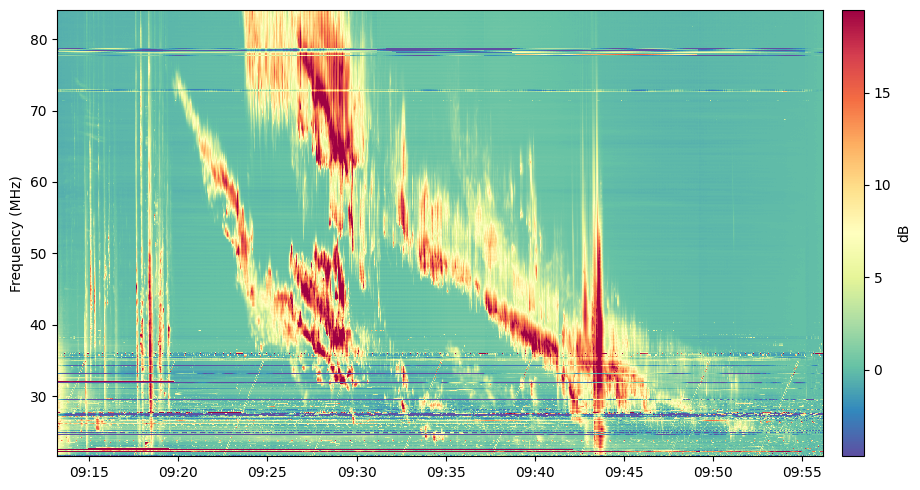

In [52]:
fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(times, freqs, background_subtracted.T,
                   vmin=np.percentile(background_subtracted, 1),
                   vmax=np.percentile(background_subtracted, 99),
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

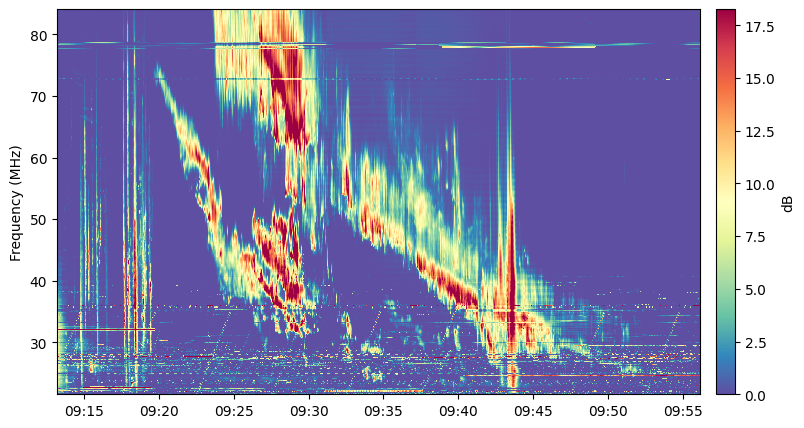

In [61]:
dyspec_subtracted = background_subtracted - np.tile(np.nanmedian(background_subtracted,0), (background_subtracted.shape[0],1))

fig, ax = plt.subplots(figsize=[10,5])
pc = ax.pcolormesh(times, freqs, dyspec_subtracted.T,
                   vmin=0,
                   vmax=np.percentile(dyspec_subtracted, 99),
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()